In [156]:
from zget_data import get_responses, get_qdetails, get_questions, get_design, page_map, quest_map, attention, did_map
from scipy.stats import shapiro, yeojohnson, kruskal
import scikit_posthocs as sp
from collections import defaultdict
from selenium import webdriver
from selenium.webdriver.common.by import By
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os, json

pfile = "data/password/pstrength.json"
qpath = "data/qualitative/"
csvpath = "data/csvs"

In [157]:
password_response, time_response, survey_response, dids = get_responses()

Total: 120; 
Attentive: 104; Non Attentive: 16


In [158]:
password_response_df = pd.DataFrame(password_response)
passwords = password_response_df['password2'].to_list()

pass_strength = {}

if os.path.exists(pfile):
    with open(pfile, "r") as fp:
        pass_strength.update(json.load(fp))
else:
    driver = webdriver.Chrome()
    driver.get("https://passwordmonster.com")

    for pss in passwords:
        element = driver.find_element(By.ID, 'lgd_out_pg_pass')
        element.send_keys(pss)
        element.clear()
        complexity = driver.find_element(By.ID, 'complexity-span')
        pass_strength[pss] = complexity.get_attribute("innerHTML")

    with open(pfile, "w") as fp:
        json.dump(pass_strength, fp)

In [159]:
pass_stmap = {
    'Very Weak': -3,
    'Weak': -1.5,
    'Medium': 0,
    'Strong': 1.5,
    'Very Strong': 3,
}
password_response_df['Actual Strength'] = password_response_df['password2'].apply(lambda x: pass_stmap.get(pass_strength.get(x)))
password_response_df

,password2,password2_recall1,password2_recall2,password2_recall3,Actual Strength
0,Laverne1991*,NaN,NaN,NaN,-1.5
1,Aksh4aya%dm,NaN,NaN,NaN,3.0
2,987654321,NaN,NaN,NaN,-3.0
3,IMTFITNAAT,IMTFAATITN,IMTFAATITN,IMTFAATITN,1.5
4,MTiaPITA4!,NaN,NaN,NaN,1.5
...,...,...,...,...,...
99,I7stgawtg?,NaN,NaN,NaN,3.0
100,bm@1994,NaN,NaN,NaN,-1.5
101,lwaa(fas,NaN,NaN,NaN,1.5
102,Iga5afft1m!w,Iga5afft1mw!,NaN,NaN,3.0


In [160]:
survey_response_df = pd.DataFrame(survey_response)

page_id = '3'
normqsid = ['1-1', '1-4']
fpass = pd.DataFrame(survey_response_df[page_id].to_dict()).astype(int)
normfpass = 8 - fpass.loc[normqsid]
fpass.update(normfpass)

new_index = {}
for qsid in fpass.index:
    likert_scale = 'low' if qsid in normqsid else 'high'
    new_index[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"').split('\n')[1]).get('title')
fpass.rename(columns=new_index, inplace=True)
fpass = fpass.rename(new_index)
password_generation = pd.DataFrame(fpass.T.mean(axis=1), columns=['Password Generation'])
pg_prenorm = password_generation.join(pd.DataFrame([get_design(str(did)) for did in dids], columns=['design']))

# normalize scale 1 to 8 to scale -3 to 3
normspassb = password_generation - 4
password_generation.update(normspassb)

In [161]:
page_id = '12'
normqsid = []
spass = pd.DataFrame(survey_response_df[page_id].to_dict())

qualindex = ['8-1']
spassqual = spass.loc[qualindex]
spassqual.to_csv(os.path.join(qpath, 'spass_qual.csv'))

spassquant = spass.drop(qualindex).fillna(0).astype(int)
spass.drop(attention.get(page_id), inplace=True)

normqsid = []
normspassquant = 8 - spassquant.loc[normqsid]
spassquant.update(normspassquant)

# normalize scale 1 to 8 to scale -3 to 3
normspassb = spassquant - 4
spassquant.update(normspassb)

new_index = {}
for qsid in spassquant.index:
    new_index[qsid] = json.loads(get_qdetails(page_id, qsid).replace("'", '"').split('\n')[1]).get('title')
new_index
spassquant = spassquant.rename(new_index)
spassquant['mean'] = spassquant.mean(axis=1)
spassquant['median'] = spassquant.median(axis=1)
display(spassquant.head())
spassquant.drop(['mean', 'median'], axis=1, inplace=True)
spassquant = spassquant.T

,0,1,2,3,4,5,6,7,8,9,...,96,97,98,99,100,101,102,103,mean,median
Strength of password,2,2,2,1,1,2,2,3,1,3,...,3,2,2,2,2,1,3,0,2.009615,2.0
Motivation,2,2,0,2,0,2,1,2,3,0,...,3,1,3,2,2,0,3,2,1.971154,2.0
Hard to remember,-3,2,2,3,-1,-2,3,-1,0,3,...,1,2,-1,-1,3,0,2,0,0.038462,0.0
Can be easily guessed by a hacker,-3,-1,0,-3,-2,-3,2,-2,-2,-3,...,-3,1,-2,-1,3,1,-3,2,-1.365385,-2.0
Can be easily guessed by my close friends or family members,-3,-1,2,-3,-3,-3,2,-3,-3,-3,...,-3,2,-2,-3,2,-1,-3,1,-1.461538,-3.0


In [162]:
password = spassquant.join(password_generation).join(password_response_df['Actual Strength']).join(pd.DataFrame([get_design(str(did)) for did in dids], columns=['design']))
password.to_csv(os.path.join(csvpath, 'password.csv'), index=False)
display(password.tail())
display(password.mean())

,Strength of password,Motivation,Hard to remember,Can be easily guessed by a hacker,Can be easily guessed by my close friends or family members,Stronger than the passwords I usually use,Second option,Helpful,Easy to think personal memory,Difficult for number and character,Password Generation,Actual Strength,design
99,2,2,-1,-1,-3,0,-2,1,3,-1,2.25,3.0,infographics
100,2,2,3,3,2,2,-2,2,2,2,-0.50,-1.5,reflection
101,1,0,0,1,-1,1,-2,1,0,-1,0.00,1.5,onlinechat
102,3,3,2,-3,-3,3,-2,3,3,-3,2.75,3.0,reflection
103,0,2,0,2,1,3,-2,1,2,1,0.75,-1.5,onlinechat


/tmp/ipykernel_179353/3288725578.py:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  display(password.mean())


Strength of password                                           2.009615
Motivation                                                     1.971154
Hard to remember                                               0.038462
Can be easily guessed by a hacker                             -1.365385
Can be easily guessed by my close friends or family members   -1.461538
Stronger than the passwords I usually use                      1.403846
Second option                                                 -2.000000
Helpful                                                        1.798077
Easy to think personal memory                                  1.509615
Difficult for number and character                            -0.153846
Password Generation                                            0.430288
Actual Strength                                                0.634615
dtype: float64

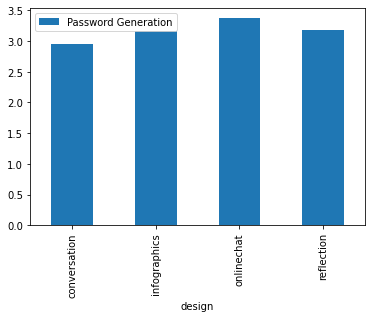

In [163]:
_ = pg_prenorm.groupby('design').mean().div(7).mul(5).plot.bar()

# overall mean
# pg_prenorm.mean().div(7).mul(5).plot.bar()

/tmp/ipykernel_179353/1550836245.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pg_prenorm.mean().div(7).mul(5).plot.bar()


<AxesSubplot:>

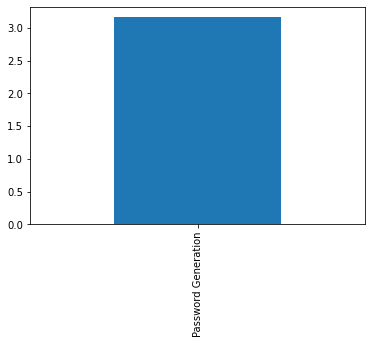

In [165]:
password

,Strength of password,Motivation,Hard to remember,Can be easily guessed by a hacker,Can be easily guessed by my close friends or family members,Stronger than the passwords I usually use,Second option,Helpful,Easy to think personal memory,Difficult for number and character,Password Generation,Actual Strength,design
0,2,2,-3,-3,-3,1,-2,2,2,2,-1.00,-1.5,reflection
1,2,2,2,-1,-1,0,-2,2,1,2,0.75,3.0,infographics
2,2,0,2,0,2,3,-2,-1,2,1,-0.50,-3.0,reflection
3,1,2,3,-3,-3,-1,-2,0,-2,3,0.25,1.5,conversation
4,1,0,-1,-2,-3,2,-2,2,-3,-3,1.25,1.5,infographics
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,2,2,-1,-1,-3,0,-2,1,3,-1,2.25,3.0,infographics
100,2,2,3,3,2,2,-2,2,2,2,-0.50,-1.5,reflection
101,1,0,0,1,-1,1,-2,1,0,-1,0.00,1.5,onlinechat
102,3,3,2,-3,-3,3,-2,3,3,-3,2.75,3.0,reflection


In [166]:
len(password_response_df['password2_recall1'].dropna()), len(password_response_df['password2_recall2'].dropna()), len(password_response_df['password2_recall3'].dropna())

(12, 7, 6)

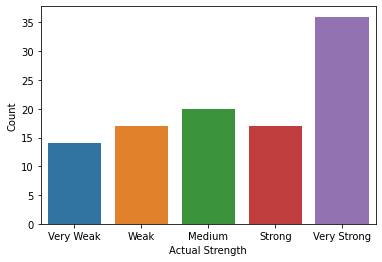

In [167]:
strength_count = password['Actual Strength'].apply(lambda x: list(pass_stmap.keys())[list(pass_stmap.values()).index(x)]).value_counts().rename_axis("Actual Strength").reset_index(name="Count")
print(strength_count)
_ = sns.barplot(data=strength_count, x='Actual Strength', y='Count', order=['Very Weak', 'Weak', 'Medium', 'Strong', 'Very Strong'])

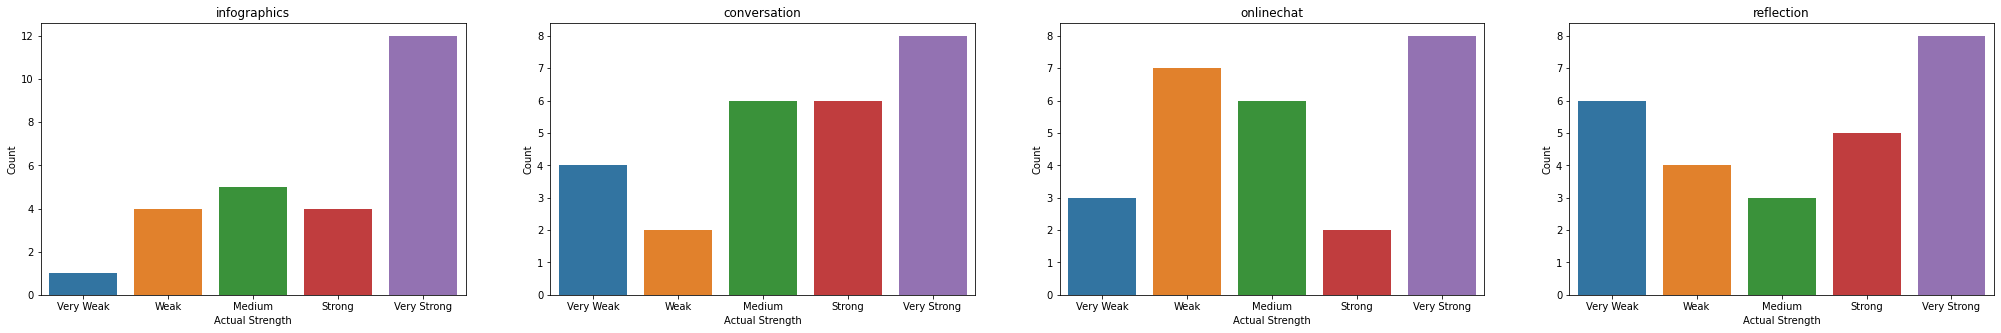

In [168]:
fig, axes = plt.subplots(1, len(did_map),  figsize=(35, 5))
temp = password[['Actual Strength', 'design']]

def get_strength(x):
    return list(pass_stmap.keys())[list(pass_stmap.values()).index(float(x))]


for i, design in enumerate(did_map.values()):
    df = temp[temp['design']==design]['Actual Strength']
    strength_count = df.apply(lambda x: get_strength(x)).value_counts().rename_axis("Actual Strength").reset_index(name="Count")
    sns.barplot(data=strength_count, x='Actual Strength', y='Count', order=['Very Weak', 'Weak', 'Medium', 'Strong', 'Very Strong'], ax= axes[i])
    axes[i].set_title(design)

In [169]:
temp.groupby('design')['Actual Strength'].mean()

design
conversation    0.692308
infographics    1.269231
onlinechat      0.288462
reflection      0.288462
Name: Actual Strength, dtype: float64

In [170]:
test = {}
designs = []
quests = temp.columns.to_list()
quests.remove('design')
for i, param in enumerate(quests):
    test[param] = []
    for design in did_map.values():
        test[param].append(temp[temp['design']==design][param].to_list())
        designs.append(design) if i<=0 else None
# test

In [171]:
# Performing kruskal test
for k, v in test.items():
    print(f'{k}: {kruskal(*v)}')

Actual Strength: KruskalResult(statistic=3.3933987446919125, pvalue=0.3348533888605506)


<AxesSubplot:>

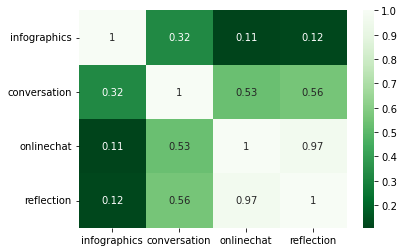

In [172]:
data = sp.posthoc_dunn(test[quests[0]])
data.index = data.index.map(get_design)
data.columns = data.columns.map(get_design)
_ = sns.heatmap(data, annot=True, cmap="Greens_r")